In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pkbar
import time
import tensornetwork as tn
from tensornetwork import contractors
backend = 'pytorch'

In [10]:
class K_Spin(object):
    
    def __init__(self, s_size, a_size, k, data=None):
        '''
        args: 
            s_size: the cardinality of the state space
            a_size: the cardinality of the action space
            k: the number of interacting states
        '''
        super(K_Spin, self).__init__()
        self.k = k
        self.s_size = s_size
        self.a_size = a_size
        
        if data is not None:
            self.leaf = data.detach().clone()
        else:
            self.leaf = torch.randn((s_size * a_size, 1))
        self.leaf.requires_grad = True
        
        self.data = self.softmax_by_state()
        self.qubits = self.create_qubits()
        self.outer_product_chain()

    
    def softmax_by_state(self):
        '''
        returns:
            updated data tensor after doing a softmax operation
            with regard to each of the states
        '''
        states = []
        softmax = torch.nn.Softmax(dim=0)
        for s in range(self.s_size):
            state = self.leaf[s * self.a_size : (s+1) * self.a_size, :]
            states.append(softmax(state))
        return torch.cat(states, dim=0)
        
        
    def outer_product_chain(self):
        '''
        modifies:
            connects the qubits into a tensor network that
            computes the outer product when contracted
        '''
        self.qubits[0][1] ^ self.qubits[1][1]
        for k in range(1, self.k - 1):
            self.qubits[k][2] ^ self.qubits[k + 1][1]


    def create_qubits(self):
        '''
        returns:
            a list of qubits (nodes) with suitable dimensions
            (may contain dummy dimensions)
        '''
        qubits = []
        backend = 'pytorch'
        for i in range(self.k):
            if i == 0 or i == self.k - 1:
                q = tn.Node(self.data, backend=backend)
            else:
                q = tn.Node(self.data.unsqueeze(-1), backend=backend)
            qubits.append(q)
        return qubits

In [11]:
def learning_rate(init, epoch):
    return init * 0.9999 ** epoch

In [88]:
epochs = int(5e3)
k = 2
s, a = 25, 4
data = None
energy_history = []
lr = 0.001
Pbar = pkbar.Pbar(name='progress', target=epochs)
for e in range(epochs):
    spins = K_Spin(s, a, k, data=data)
    for i in range(k):
        B[i] ^ spins.qubits[i][0]
    
    energy = contractors.branch(tn.reachable(B), nbranch=1).get_tensor()
    energy.backward()
    energy_history.append(-energy)

    data = spins.leaf + spins.leaf.grad * learning_rate(lr, e)
    Pbar.update(e)

progress
5000/5000  [==============================] - 13.9s


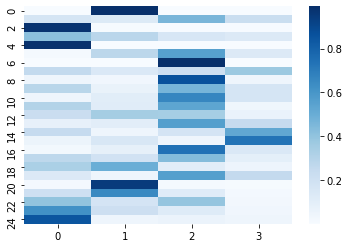

In [89]:
result = spins.data.reshape(s, a).detach().numpy()
ax = sns.heatmap(result, cmap="Blues")
plt.xlabel = 'States'
plt.show()

In [65]:
target = torch.tensor(
 [[21.97748529, 24.4194281, 21.97748529, 19.4194281, 17.47748529],
 [19.77973676, 21.97748529, 19.77973676, 17.80176308, 16.02158677],
 [17.80176308, 19.77973676, 17.80176308, 16.02158677, 14.4194281],
 [16.02158677, 17.80176308, 16.02158677, 14.4194281, 12.97748529],
 [14.4194281, 16.02158677, 14.4194281, 12.97748529, 11.67973676]])

In [90]:
policy = torch.empty(s)
p = torch.tensor(result)
for i in range(s):
    policy[i] = torch.argmax(p[i, :])

In [96]:
optimal = torch.zeros(s)
t = target.reshape(s)
print(t)
temp = torch.zeros(s)
for i in range(s):
    for j in range(s):
        for act in range(a):
            if P[i, act, j] == 1 and t[j] >= temp[i]:
                optimal[i] = act
                temp[i] = t[j]

tensor([21.9775, 24.4194, 21.9775, 19.4194, 17.4775, 19.7797, 21.9775, 19.7797,
        17.8018, 16.0216, 17.8018, 19.7797, 17.8018, 16.0216, 14.4194, 16.0216,
        17.8018, 16.0216, 14.4194, 12.9775, 14.4194, 16.0216, 14.4194, 12.9775,
        11.6797])


In [97]:
optimal.reshape(5, 5)

tensor([[1., 3., 0., 3., 1.],
        [1., 2., 0., 0., 1.],
        [1., 2., 0., 0., 1.],
        [1., 2., 0., 0., 1.],
        [1., 2., 0., 0., 0.]])

In [98]:
policy.reshape(5, 5)

tensor([[1., 2., 0., 0., 0.],
        [2., 2., 3., 2., 2.],
        [2., 2., 1., 2., 3.],
        [3., 2., 2., 1., 2.],
        [1., 1., 0., 0., 0.]])

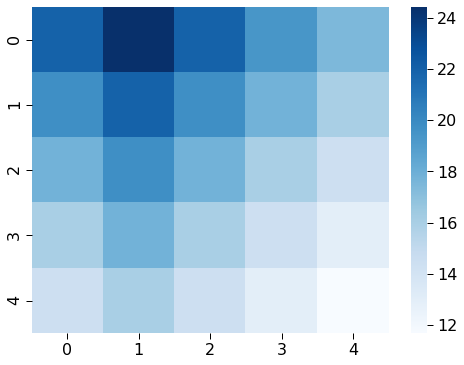

In [18]:
sns.heatmap(target, cmap='Blues')

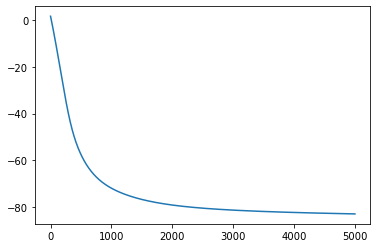

In [79]:
# with plt.style.context(['science', 'notebook']):
plt.plot(energy_history[:5000])
plt.title='Policy Iteration using K-Spin Hamiltonian'
plt.xlabel='Number of iterations'
plt.ylabel='Energy'

plt.show()

In [3]:
s, a = 25, 4

# states: scan from left to right
# actions: left, right, top, down

R = torch.zeros((s, a)) 
for i in range(s):
    if i % 5 == 0:
        R[i, 0] = -1
    if (i - 4) % 5 == 0:
        R[i, 1] = -1
    if i in range(5):
        R[i, 2] = -1
    if i in range(s - 5, s):
        R[i, 3] = -1
R[1, :] = 10
R[3, :] = 5

In [92]:
b = torch.empty([s * a] * 3, dtype=torch.float32)
# P[k // a, k % a, sk] 
# P[j // a, j % a, sk]
gamma = 0.9
pbar = pkbar.Pbar(name='initialize H', target=(s * a))
for i in range(s * a):
    pbar.update(i)
    for j in range(s * a):
        for k in range(s * a):
            in_edge = torch.sum(P[..., i // a])
            # print(in_edge)
            J = P[s0, a0, i // a] * \
                P[i // a, i % a, j // a] * \
                P[j // a, j % a, k // a] * \
                R[k // a, k % a] * \
                in_edge
            b[i, j, k] = gamma ** 3 * J

initialize H
100/100  [==============================] - 45.3s


In [4]:
# s_t, a, s_(t+1)
P = torch.zeros((s, a, s)) 
for i in range(s):
    if i % 5 == 0:
        P[i, 0, i] = 1
    if (i - 4) % 5 == 0:
        P[i, 1, i] = 1
    if i in range(5):
        P[i, 2, i] = 1
    if i in range(s - 5, s):
        P[i, 3, i] = 1    
        
    for j in range(s):
        if j == i - 1:
            P[i, 0, j] = 1
        if j == i + 1:
            P[i, 1, j] = 1
        if j == i - 5:
            P[i, 2, j] = 1   
        if j == i + 5:
            P[i, 3, j] = 1
    if i == 1:        
        P[i, :, :] = 0
        P[i, :, 21] = 1
    if i == 3:
        P[i, :, :] = 0
        P[i, :, 13] = 1

In [13]:
B = tn.Node(b, backend=backend)

In [336]:
vecs1, diags, vecs2_h, _ = tn.split_node_full_svd(B, [B[0], B[1]], [B[2], B[3]], 30)

In [331]:
vecs1.get_tensor().shape

torch.Size([25, 25, 30])